<a href="https://colab.research.google.com/github/robynoconnor/pubpol2130/blob/main/Week3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q census us folium geopandas colorcet

In [ ]:
%config InlineBackend.figure_formats = ["retina"]

import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import folium
import colorcet as cc

from census import Census

In [ ]:
census = Census("", year=2020)

# Week 3: Exploring the U.S. Census, part 2 (units, hierarchies, the central spine, ACS)

Last week, we examined some of the demographic data published by the U.S. Census Bureau. That demographic data is associated with geographic units: for instance, we examined population by race (and Hispanic/Latin origin) at the county level. To make sense of this data beyond basic summary statistics, it is extremely useful to superimpose it on a map. This week, we'll explore how to download and visualize Census geographies, and we'll create combine demographic data with these geographies to create [choropleth maps](https://en.wikipedia.org/wiki/Choropleth_map).

## Loading geographical data

Census geographies are published as _shapefiles_. The [ESRI shapefile format](https://en.wikipedia.org/wiki/Shapefile) is extremely popular among GIS (geographic information systems) practictioners, and any serious mapping tool (such as [ArcGIS](https://www.arcgis.com/index.html)) can read shapefiles. [GeoPandas](https://geopandas.org/en/stable/getting_started/introduction.html) is a Python package that extends Pandas to support reading shapefiles and plotting geographies; we'll use this package extensively in the coming weeks to build geospatial visualizations. Let's start by downloading a shapefile containing the outlines of all U.S. counties from the Census website.

In [4]:
county_gdf = gpd.read_file("https://web.archive.org/web/20241002004532if_/https://www2.census.gov/geo/tiger/TIGER2024/COUNTY/tl_2024_us_county.zip").set_index("GEOID")

In [5]:
county_gdf.head(5)

,STATEFP,COUNTYFP,COUNTYNS,GEOIDFQ,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
GEOID,,,,,,,,,,,,,,,,,,
31039,31,039,00835841,0500000US31039,Cuming,Cuming County,06,H1,G4020,None,None,None,A,1477563042,10772508,+41.9158651,-096.7885168,"POLYGON ((-96.55525 41.82892, -96.55524 41.827..."
53069,53,069,01513275,0500000US53069,Wahkiakum,Wahkiakum County,06,H1,G4020,None,None,None,A,680980773,61564428,+46.2946377,-123.4244583,"POLYGON ((-123.72755 46.2645, -123.72756 46.26..."
35011,35,011,00933054,0500000US35011,De Baca,De Baca County,06,H1,G4020,None,None,None,A,6016818941,29090018,+34.3592729,-104.3686961,"POLYGON ((-104.89337 34.08894, -104.89337 34.0..."
31109,31,109,00835876,0500000US31109,Lancaster,Lancaster County,06,H1,G4020,339,30700,None,A,2169269508,22850511,+40.7835474,-096.6886584,"POLYGON ((-96.68493 40.5233, -96.69219 40.5231..."
31129,31,129,00835886,0500000US31129,Nuckolls,Nuckolls County,06,H1,G4020,None,None,None,A,1489645201,1718484,+40.1764918,-098.0468422,"POLYGON ((-98.2737 40.1184, -98.27374 40.1224,..."


GeoPandas includes a `.plot()` function (similar to the `.plot.pie()` and `.plot.bar()` Pandas functions we saw last week). With this function, we can quickly get a sense of what `county_gdf` contains.

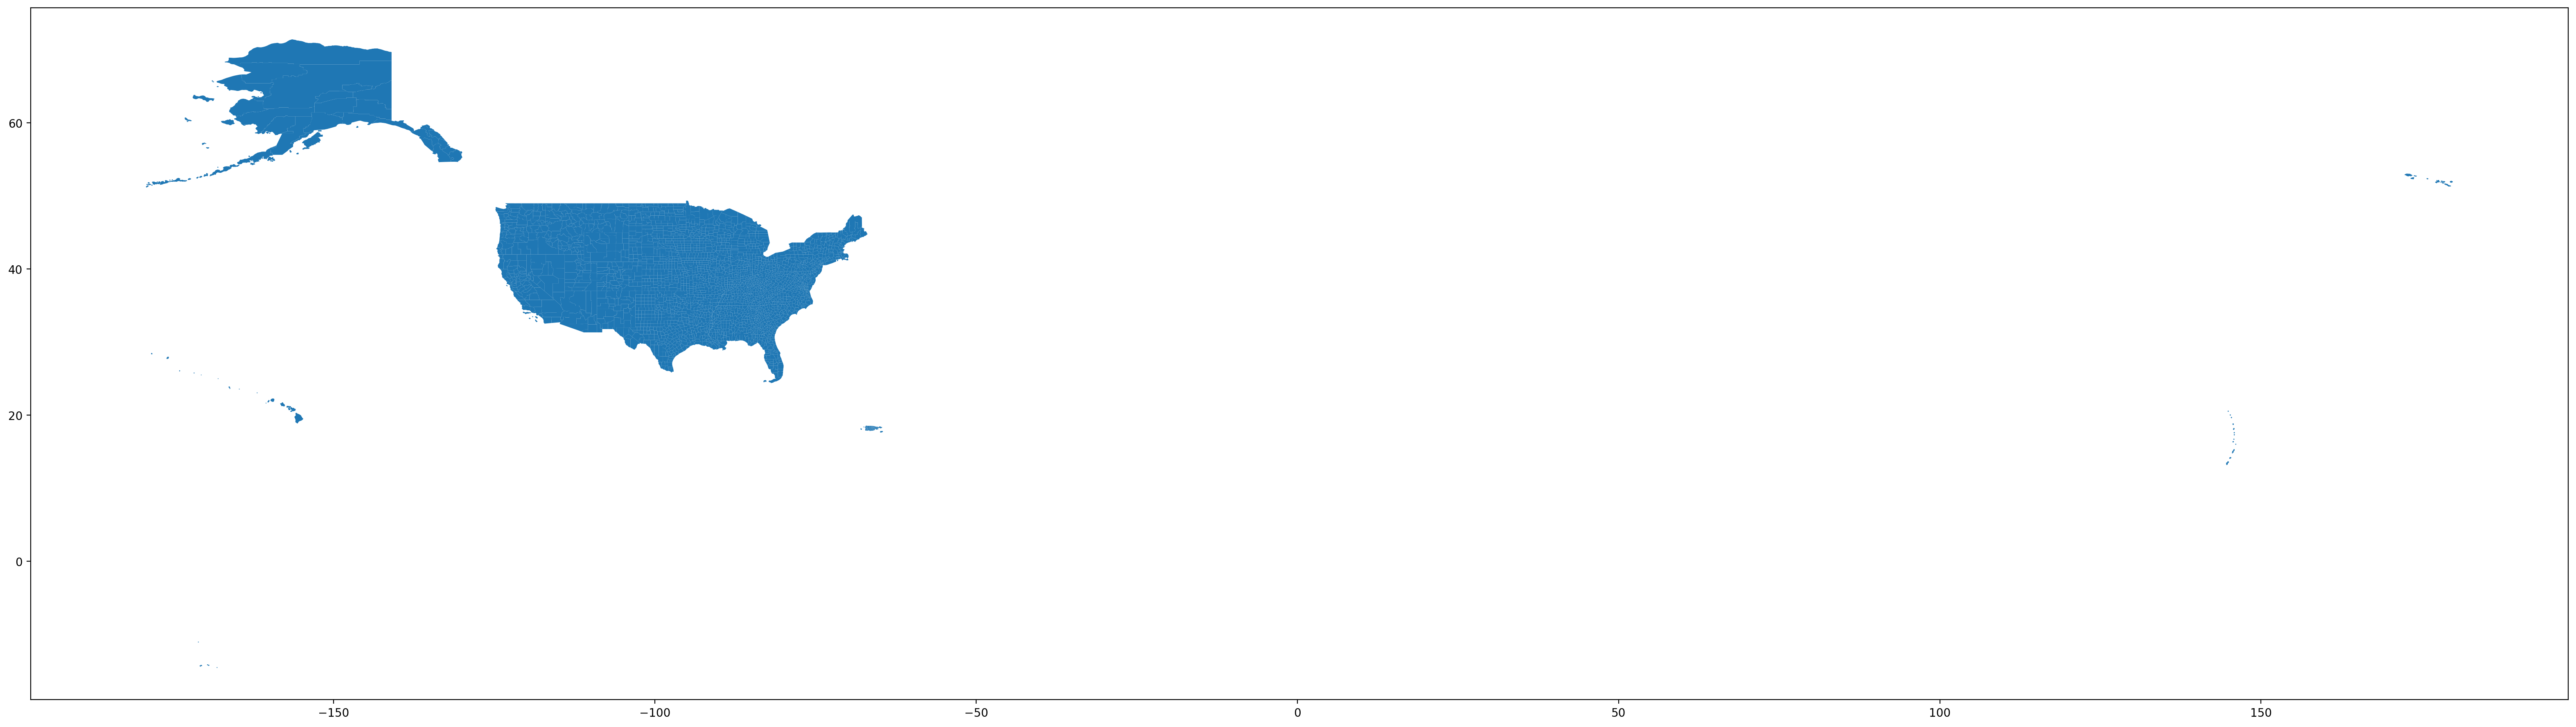

In [6]:
county_gdf.plot(figsize=(40, 80))
plt.show()

There's a problem with this initial visualization: it's mostly empty space! This is because the county shapefile covers _all_ territories of the U.S., including some Pacific territories (Guam, American Samoa, and the Northern Mariana Islands) that appear in the upper right of this plot. Let's narrow down the visualization to the continental U.S by filtering on FIPS code (conveniently, the outlying territories all have FIPS codes above 56).

In [7]:
# Filter out American Samoa, U.S. Virgin Islands, etc.
continental_gdf = county_gdf[
      (county_gdf.STATEFP <= "56")
    & (county_gdf.STATEFP != "02")  # exclude Alaska
    & (county_gdf.STATEFP != "15")  # exclude Hawaii
]

In [ ]:
continental_gdf.plot(figsize=(20, 40))
plt.show()

That's better! Now, let's color the map by state (using the `STATEFP` column, which contains the state FIPS code for each county). Note that some of the state borders look a little odd (this effect is most pronounced in Michigan); this is because the Census geographies include some water areas.

In [ ]:
continental_gdf.plot(figsize=(20, 40), column="STATEFP", cmap=cc.cm.glasbey_hv)
plt.show()

## Choosing a map projection

You may have noticed something about the shape of the country not looking "right" -- that's because this is what the geographers call "unprojected," meaning that it uses latitude and longitude for its x and y coordinates directly, rather than transforming them to better represent either angles or areas.

ref:
* [Choosing the right map projection](https://source.opennews.org/articles/choosing-right-map-projection/)
* [geopandas.GeoDataFrame.plot()](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.plot.html)

In [ ]:
continental_gdf.crs

In [ ]:
continental_gdf = continental_gdf.to_crs("EPSG:2163")

In [ ]:
continental_gdf.crs

In [ ]:
continental_gdf.plot(figsize=(20, 40), column="STATEFP", cmap=cc.cm.glasbey_hv, edgecolor="0.2", linewidth=0.5)
plt.axis("off")
plt.show()

## The Census unit hierarchy

The core Census geographic units are organized into hierarchy (sometimes referred to as _the central spine_): states contain counties, which contain _tracts_, which contain _block groups_, which contain _blocks_. States and counties are (mostly) static political units with boundaries generally not determined by the Census; tracts, block groups, and blocks are statistical units defined by the Census. These statistical units are subject to change for each decennial Census. Blocks are the most granular unit in this hierarchy, and [many Census blocks are unpopulated](https://mapsbynik.com/maps/census0pop/).

![U.S. Census central spine (source: University of Missouri)](https://mcdc.missouri.edu/geography/sumlevs/censusgeochart.png)

_(image credit: University of Missouri)_

The Census also publishes data for political and statistical areas that do not fall neatly in this spine. For instance, school districts nest in states, but they do not necessarily nest in counties; voting districts nest in counties, but not necessarily in tracts.

Let's examine how the state of New York is broken up into various Census units, starting with counties—the least granular unit (below the state level) on the central spine.

### Counties
The U.S. Census releases a county shapefile at the national level; to plot just the counties in New York, we need to filter by state FIPS code.

In [ ]:
la_county_gdf = continental_gdf[continental_gdf.STATEFP == "22"]

In [ ]:
la_county_gdf.head(5)

In [ ]:
la_county_gdf.plot(figsize=(10, 20), edgecolor="0.2", linewidth=0.5)
plt.axis("off")
plt.show()

### County subdivisions

For reporting purposes, the Census divides counties into _county subdivisions_. These subdivisions generally avoid dividing up preexisting political divisions: towns, cities, incorporated places, and the like. (For more on how county subdivisions are defined, see [chapter 8 of the _Geographic Areas Reference Manual_](https://www2.census.gov/geo/pdfs/reference/GARM/Ch8GARM.pdf).)

In [ ]:
la_cousub_gdf = gpd.read_file("https://web.archive.org/web/20241002180257if_/https://www2.census.gov/geo/tiger/TIGER2024/COUSUB/tl_2024_22_cousub.zip").set_index("GEOID").to_crs("EPSG:2163")

In [ ]:
la_cousub_gdf.head(5)

In [ ]:
la_cousub_gdf.plot(figsize=(10, 20), column="COUNTYFP", cmap=cc.cm.glasbey_hv, edgecolor="0.2", linewidth=0.5)
plt.axis("off")
plt.show()

### Tracts
Census tracts are immediately below counties on the central spine. While counties in New York (and most states) vary wildly in population, the populations of Census tracts are much more constrained: [according to the U.S. Census](https://www.census.gov/programs-surveys/geography/about/glossary.html#par_textimage_13), "Census tracts generally have a population size between 1,200 and 8,000 people, with an optimum size of 4,000 people". Because of this uniformity, the density of Census tracts roughly corresponds to population density. In the map below, observe the high density of small tracts in major population centers like New York City and the low density of large tracts in the sparsely populated upstate regions.

In [ ]:
la_tract_gdf = gpd.read_file("https://web.archive.org/web/20241003052404if_/https://www2.census.gov/geo/tiger/TIGER2024/TRACT/tl_2024_22_tract.zip").set_index("GEOID").to_crs("EPSG:2163")

In [ ]:
la_tract_gdf.head(5)

In [ ]:
la_tract_gdf.plot(figsize=(10, 20), column="COUNTYFP", cmap=cc.cm.glasbey_hv, edgecolor="0.2", linewidth=0.5)
plt.axis("off")
plt.show()

We can filter by FIPS code to zoom in on a particular county. Here is Kings County, which is coterminous with the borough of Brooklyn.

In [ ]:
new_orleans_tract_gdf = la_tract_gdf[la_tract_gdf.COUNTYFP == "071"]

In [ ]:
new_orleans_tract_gdf.head(5)

In [ ]:
new_orleans_tract_gdf.plot(figsize=(10, 10), edgecolor="0.2", linewidth=0.5)
plt.axis("off")
plt.show()

We can see that Census tracts, being composed of census blocks (which are often themselves equal to city blocks), generally follow the city's grid.

<img width="512" alt="Brooklyn neighborhoods map" src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/f2/Brooklyn_neighborhoods_map.png/512px-Brooklyn_neighborhoods_map.png?20090719024832">

_(image credit: <a href="https://commons.wikimedia.org/wiki/File:Brooklyn_neighborhoods_map.png">Peter Fitzgerald</a>, <a href="https://creativecommons.org/licenses/by/3.0">CC BY 3.0</a>, via Wikimedia Commons)_

# Introducing ACS data

In addition to publishing decennial data, the U.S. Census Bureau publishes [American Community Survey](https://www.census.gov/programs-surveys/acs) (ACS) data every year. The ACS is sent to a random sample of U.S. addresses; ACS data includes population estimates by race and ethnicity (which is useful for understanding demographic shifts between decennial Censuses), but it is also an invaluable source for understanding economic and social trends. As a simple example, let's take a look at a subset of the means of transportation data available in the ACS.

In [ ]:
new_orleans_subway_usage_raw = census.acs5.get(
    (
        # Means of Transportation to Work – Total
        "B08301_001E",
        # Means of Transportation to Work – Total – Public transportation (excluding taxicab) – Subway or elevated rail
        "B08301_012E",
    ),
    geo={
        "for": "tract:*",
        "in": f"state:22 county:071",
    },
    year=2022,
)

In [ ]:
new_orleans_subway_usage_df = pd.DataFrame(new_orleans_subway_usage_raw).rename(
    columns={
        "B08301_001E": "commuter_count",
        "B08301_012E": "subway_commuter_count",
    }
)

In [ ]:
new_orleans_subway_usage_df

In [ ]:
new_orleans_subway_usage_df["GEOID"] = (
    new_orleans_subway_usage_df["state"]
    + new_orleans_subway_usage_df["county"]
    + new_orleans_subway_usage_df["tract"]
)
new_orleans_subway_usage_df = new_orleans_subway_usage_df.set_index("GEOID")
new_orleans_subway_usage_df["subway_pct"] = 100 * new_orleans_subway_usage_df["subway_commuter_count"] / new_orleans_subway_usage_df["commuter_count"]

In [ ]:
new_orleans_subway_usage_df.sort_values(by=["subway_pct"])

In [ ]:
new_orleans_subway_usage_df = new_orleans_subway_usage_df[new_orleans_subway_usage_df.commuter_count > 0]

In [ ]:
new_orleans_subway_usage_gdf = new_orleans_tract_gdf.join(new_orleans_subway_usage_df)

In [ ]:
ax = new_orleans_subway_usage_gdf.plot(figsize=(10, 10), column="commuter_count", legend=True)
ax.axis("off")
ax.set_title("Subway usage by commuters (%)")
plt.show()

In [ ]:
subway_map = folium.Map([40.65, -73.95], zoom_start=12)
folium.GeoJson(brooklyn_subway_usage_gdf).add_to(subway_map)
subway_map

In [ ]:
subway_map = folium.Map([40.65, -73.95], zoom_start=12)
folium.Choropleth(
    geo_data=brooklyn_subway_usage_gdf,
    name="choropleth",
    data=brooklyn_subway_usage_gdf,
    columns=["NAMELSAD", "subway_pct"],
    key_on="feature.properties.NAMELSAD",
    fill_color="YlGn",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Unemployment Rate (%)",
).add_to(subway_map)
subway_map

#Homework 3, due Thursday Feb 20, 1:25pm

(This takes the exam and Feb break into account.)

The **data product** part of your homework is to make an interesting choropleth using ACS data!  You pick the geography and the variables to visualize.

The **reading response** part of your homework comes from the Monmonier chapter.  Monmonier tells lots of stories of sloppy mapping, theft by mapping, and fights over mapping.  Pick one story and briefly describe whether/how the story involves dueling experts, physical tools, map notation, money, and legal authority.